In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin
from tqdm import tqdm
import pandas as pd
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Рассмотрим следующий временной ряд:

$$x_t=\frac{5\cos(2 \pi \eta_t)}{1 - 0.5 \eta_t} + \varepsilon_t,\quad t=1,\ldots,n$$
где $\eta_t=\sum\limits_{k=1}^p \phi_{k}x_{t-k}$, $\varepsilon\sim N(0, 1)$.

In [2]:
def generate_ar(coeffs, n, init, scale=1):
    p = len(coeffs)
    noise = np.random.normal(0, scale, n)
    series = np.zeros(n + p)
    series[:p] = init
    for i in range(p, n + p):
        dotprod = np.dot(coeffs, series[i - p:i][::-1])
        series[i] = 5 * np.cos(2 * np.pi * dotprod) / (1 - 0.5 * dotprod) + noise[i - p]
    return series[p:]

Пусть $p=100$, $n=5000$, $\phi_k=(-0.1)^k$.

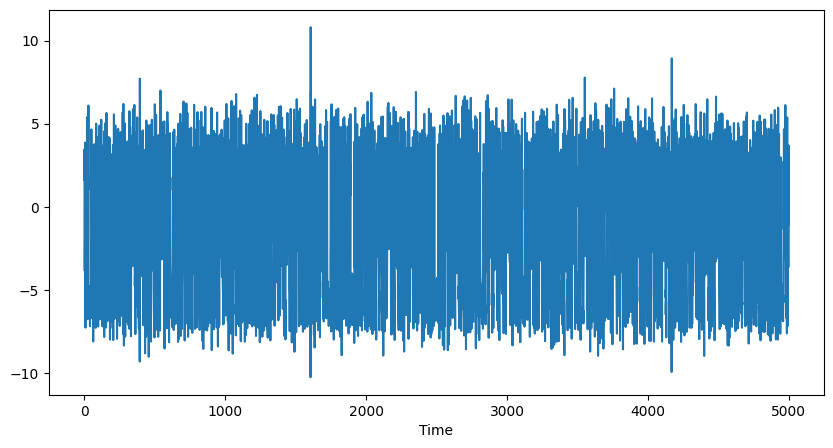

In [3]:
np.random.seed(123)

n, p = 5000, 100
ar = [(-0.1) ** i for i in range(1, p + 1)]
series = generate_ar(ar, n, init=np.random.uniform(-10, 10, p))
plt.figure(figsize=(10, 5))
plt.plot(series)
plt.xlabel('Time')
plt.show()

Обучим сверточную нейронную сеть на данном временном ряде. Для начала "свернем" ряд в матрицу:

In [4]:
# Scale the series for better convergence
series = (series - np.min(series)) / (np.max(series) - np.min(series))

# Matrix of lagged series, last column is the target
data = np.column_stack([series[i:n - p + i] for i in range(p + 1)])
data.shape

(4900, 101)

Разобьем полученный датасет на train/validation/test в соотношении 0.6/0.2/0.2:

In [5]:
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)
data_train, data_val = train_test_split(data_train, test_size=0.25, shuffle=False)

# Save data
np.save("./data/train.npy", data_train)
np.save("./data/val.npy", data_val)
np.save("./data/test.npy", data_test)

In [6]:
# Creating a custom Dataset for our data
class TimeSeriesDataset(Dataset):
    def __init__(self, root, device, type="train"):
        name = type + ".npy"
        path = pjoin(root, name)
        dataset = torch.tensor(np.load(path), dtype=torch.float32).unsqueeze(0).to(device)
        self.X = dataset[:, :, :-1]
        self.y = dataset[:, :, -1]

    def __len__(self) -> int:
        return self.X.shape[1]

    def __getitem__(self, idx):
        return self.X[:, idx, :], self.y[:, idx] 

Подготавливаем данных к обучению с помощью DataLoaders:

In [7]:
batch_size = 64
train_dataset = TimeSeriesDataset("./data", device, type="train")
train_loader = DataLoader(train_dataset, batch_size)
val_dataset = TimeSeriesDataset("./data", device, type="val")
val_loader = DataLoader(val_dataset, batch_size)
test_dataset = TimeSeriesDataset("./data", device, type="test")
test_loader = DataLoader(test_dataset, batch_size)

Будем обучать следующую нейронную сеть: Свертка с 16 каналами -> Свертка с 32 каналами -> Свертка с 64 каналами -> Линейный слой. Между свертками будем применять MaxPool с окном $2\times2$, ReLU и Batch Normalization, перед Линейным слоем будем применять Dropout с $p=0.5$.

In [8]:
class TimeSeriesCNN(nn.Module):
    def __init__(self):
        super(TimeSeriesCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding='same'),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.BatchNorm1d(16),

            nn.Conv1d(16, 32, kernel_size=3, padding='same'),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.Conv1d(32, 64, kernel_size=3, padding='same'),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(768, 1)
        )

    def forward(self, x):
        return self.net(x)

В качестве Loss возьмем MSE, оптимизатор Adam с $L_2$ регуляризацией.

In [9]:
model = TimeSeriesCNN().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    betas=(0.9, 0.99),
    weight_decay=0.1,
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 8833


In [11]:
def train_one_epoch():
    avg_loss = 0
    for inputs, targets in train_loader:
         optimizer.zero_grad()

         outputs = model(inputs)

         loss = loss_fn(outputs, targets)
         loss.backward()

         optimizer.step()

         avg_loss += loss.item() * inputs.shape[0]

    avg_loss /= len(train_loader.dataset) 
    return avg_loss

In [12]:
EPOCHS = 300
best_vloss = np.inf
train_loss, val_loss = [], []
for epoch in tqdm(range(EPOCHS)):
    model.train()
    avg_loss = train_one_epoch()

    avg_vloss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            avg_vloss += loss_fn(outputs, targets).item() * inputs.shape[0]
    
    avg_vloss /= len(val_loader.dataset)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_loss:.5f}, Validation Loss: {avg_vloss:.5f}')

    if (avg_vloss < best_vloss):
        best_vloss = avg_vloss
        torch.save(model.state_dict(), './data/model.pt')

    train_loss.append(avg_loss)
    val_loss.append(avg_vloss)

    scheduler.step()

 17%|█▋        | 51/300 [00:09<00:42,  5.88it/s]

Epoch 50/300, Train Loss: 0.01697, Validation Loss: 0.02127


 34%|███▎      | 101/300 [00:17<00:33,  5.90it/s]

Epoch 100/300, Train Loss: 0.00586, Validation Loss: 0.00658


 50%|█████     | 151/300 [00:26<00:25,  5.96it/s]

Epoch 150/300, Train Loss: 0.00407, Validation Loss: 0.00515


 67%|██████▋   | 201/300 [00:34<00:17,  5.80it/s]

Epoch 200/300, Train Loss: 0.00358, Validation Loss: 0.00505


 84%|████████▎ | 251/300 [00:42<00:07,  6.27it/s]

Epoch 250/300, Train Loss: 0.00337, Validation Loss: 0.00470


100%|██████████| 300/300 [00:50<00:00,  5.92it/s]

Epoch 300/300, Train Loss: 0.00330, Validation Loss: 0.00470


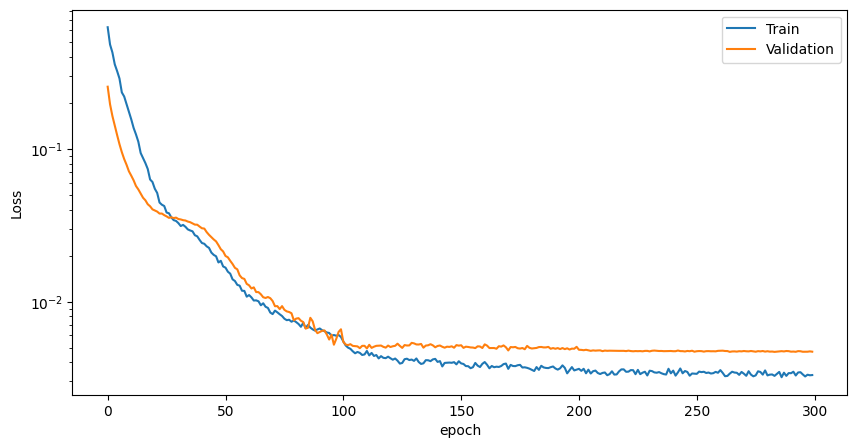

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [14]:
# Save losses
losses = pd.DataFrame({'Train': train_loss, 'Validation': val_loss})
losses.to_csv('./data/losses.csv', index=False)

Загружаем модель с наименьшим validation loss: 

In [15]:
model.load_state_dict(torch.load('./data/model.pt'))

<All keys matched successfully>

Проверка качества модели на тестовом множестве:

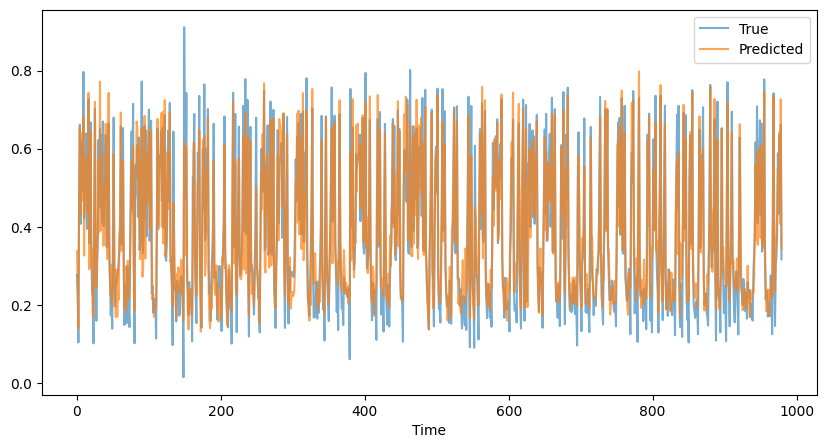

Test Loss: 0.00412


In [16]:
y_pred = []
test_loss = 0
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        y_pred.append(outputs.cpu())
        loss = loss_fn(outputs, targets)
        test_loss += loss.item() * inputs.shape[0]

y_pred = torch.cat(y_pred, dim=0).squeeze().numpy()
y_test = test_dataset.y.cpu().numpy().squeeze()
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True', alpha=0.6)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.legend()
plt.show()

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.5f}')

Первые 100 точек:

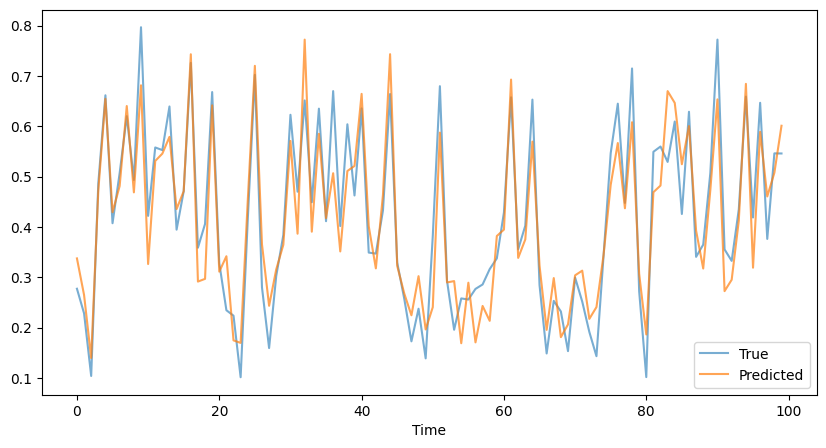

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="True", alpha=0.6)
plt.plot(y_pred[:100], label="Predicted", alpha=0.7)
plt.xlabel('Time')
plt.legend()
plt.show()